# Backpropagation

When we call ***loss.backward()*** we use PyTorch autograd to calculate all the gradients along the way. In this notebook, we are going to remove this line and instead we are going to **write all the backward pass** manually on the level of tensors.

In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Build dataset

In [3]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()

print(len(words))
print(words[:10])

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3 # context length

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])   # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte,  Yte  = build_dataset(words[n2:])   # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Intializing MLP

We are initializing `b1`, `b2`, `bngain`, `bnbias` in **non-standard ways** because sometimes initializating with all zeros could mask an incorrect implementation of the backward pass.

In [6]:
n_embd = 10   # dimensionality of the character embedding vectors
n_hidden = 64 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 4137


## Forward Pass

Forward pass, "chunkated" into **smaller steps** that are possible to backpropagate one at a time.

In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# mini-batch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [8]:
emb = C[Xb]                         # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1           # hidden layer pre-activation

# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*bndiff2.sum(0, keepdim=True) # Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact)             # hidden layer

# Linear layer 2
logits = h @ W2 + b2                # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1     # same as 1.0 / counts_sum
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
print('loss:', loss.item())

loss: 3.3120362758636475


**Note:** The [Bessel's correction](https://math.oxford.emory.edu/site/math117/besselCorrection/) paper explains why dividing by n-1 gives a better estimate of the variance when the population size or samples for the population are very small. Using 1/n almost always underestimates the variance and it is a biased estimator. Hence, it is advised using the **unbiased version of the variance** and divide by 1-n.

## PyTorch backward pass

In [9]:
for p in parameters:
  p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()

loss.backward()

# Exercise 1

**Backpropopagate manually through all of the variables as they are defined in the forward pass above.**

## Backward pass

The idea is to backpropagate the loss by calculating the derivatives of each variable so we get matrices or vectors containing the gradients.

### dlogprobs

`loss` is the negative mean of all the **log probabilities of the correct next character** in a sequence:

*loss = -logprobs[range(n), Yb].mean()*

<br>

`dlogprobs` will hold the derivative of the loss with respect to all the elements of `logprobs`.

- Let us simplify the problem to *loss = -(a + b + c) / 3*. 

- Algebraically, *loss = -1/3a -1/3b -1/3c*. 

- Then, the derivative of the loss with respect to a (or b or c) is *dloss/da = -1/3*. 

- More generally *dloss/da = -1/n*.

Thus, the derivative of the loss with respect to the **log probabilities of the correct next characters** is -1/n.

The **log probabilties of the incorrect next characters** do not participate in the calculation of the loss. Thus, the derivative of the loss with respect to them is zero.

In [10]:
dlogprobs = torch.zeros_like(logprobs) # matrix of zeros with the shape of logprobs
dlogprobs[range(n), Yb] = -1.0/n

### dprobs

`logprobs` is calculated taking the logarithm element wise of all the elements of `probs`:

*logprobs = log(probs)*

<br>

Thus, we multiply the local derivative of the above operation (*d/dx log(x) = 1/x*) times `dlogprobs`.

**Note:** This line is taking the examples that have a very low probability currently assigned and it's boosting their gradient.

In [11]:
dprobs = (1.0 / probs) * dlogprobs

### dcounts (1) and dcounts_sum_inv 

`probs` is calculated muliplying the matrix `counts` and the column vector `counts_sum_inv`:

*probs = counts * counts_sum_inv*

$$
\begin{bmatrix}
a_{11}x_1 & a_{12}x_1 & a_{13}x_1 \\
a_{21}x_2 & a_{22}x_2 & a_{23}x_2 \\
a_{31}x_3 & a_{32}x_3 & a_{33}x_3
\end{bmatrix}
=
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}
\end{bmatrix}
·
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
$$

<br>

The local derivative of `probs` with respect to `counts` is `counts_sum_inv` and with respect to `counts_sum_inv` is `counts`. Thus, we multiply these matrices times `dprobs`. In addition, the column vector `counts_sum_inv` is broadcasted so we have to sum horizontally across the rows.

**Note:** *If a node is used multiple times, the gradients of all of it uses will be summed during backpropagation.* We are multiplying some elements multiple times so we have to **sum horizontally across the rows**.

In [12]:
dcounts = counts_sum_inv * dprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

### dcounts_sum

`counts_sum_inv` is calculated rising element wise all the elements of `counts_sum` to the power of -1:

*counts_sum_inv = counts_sum<sup>-1</sup>*

<br>

Thus, we multiply the local derivative of the above operation (d/dx x<sup>-1</sup> = -x<sup>-2</sup>) times `dcounts_sum_inv`.

In [13]:
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

### dcounts (2)

`counts_sum` is calculated summing up the rows of the matrix `counts`:

*counts_sum = counts.sum(1, keepdims=True)*

$$
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
=
\begin{bmatrix}
a_{11} + a_{12} + a_{13} \\
a_{21} + a_{22} + a_{23} \\
a_{31} + a_{32} + a_{33}
\end{bmatrix}
$$

<br>


The local derivative of `counts_sum` with respect to `counts` is 1. Thus, we multiply a matrix of ones with the shape of `counts` times `dcounts_sum`.

**Note:** We already calculated `dcounts` before so we have to add these gradients with the ones calculated previously.

In [14]:
dcounts += torch.ones_like(counts) * dcounts_sum

### dnorm_logits

`counts` is calculated exponentiating element wise all the elements of `norm_logits`:

*counts = e<sup>norm_logits</sup>*

<br>

Thus, we multiply the local derivative of the above operation (d/dx e<sup>x</sup> = e<sup>x</sup>) times `dcounts`.

In [15]:
dnorm_logits = counts * dcounts

### dlogits (1) and dlogit_maxes

`norm_logits` is calculated subtracting the matrix `logits` with the column vector `logit_maxes`.

*norm_logits = logits - logit_maxes*

$$
\begin{bmatrix}
a_{11}-x_1 & a_{12}-x_1 & a_{13}-x_1 \\
a_{21}-x_2 & a_{22}-x_2 & a_{23}-x_2 \\
a_{31}-x_3 & a_{32}-x_3 & a_{33}-x_3
\end{bmatrix}
=
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}
\end{bmatrix}
-
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
$$

<br>

The local derivative of `norm_logits` with respect to `logits` is 1 and with respect to `logit_maxes` is -1. Thus, we multiply 1 and -1 times `dnorm_logits`. In addition, the column vector `logit_maxes` is broadcasted so we have to sum horizontally across the rows.

In [16]:
dlogits = dnorm_logits.clone() # copy of dnorm_logits
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

### dlogits (2)

`logit_maxes` is calculated pluging out the max number of each row of the matrix `logits`:

*logit_maxes = logits.max(1, keepdim=True).values*

$$
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
=
\begin{bmatrix}
max(a_{11} & a_{12} & a_{13}) \\
max(a_{21} & a_{22} & a_{23}) \\
max(a_{31} & a_{32} & a_{33})
\end{bmatrix}
$$

<br>

The local derivative of `logit_maxes` with respect to the maximum `logits` is 1. Thus, we only multiply those maximum `logits` times `dlogit_maxes`.

In [17]:
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

### dh, dW2, and db2

`logits` is calculated matrix multypling the matrix `h` and `W2` and adding the broadcasted vector `b2`:

*logits = h @ W2 + b2*

$$
\begin{bmatrix}
d_{11} & d_{12} \\
d_{21} & d_{22}
\end{bmatrix}
=
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22}
\end{bmatrix}
\times
\begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22}
\end{bmatrix}
+
\begin{bmatrix}
c_{1} & c_{2} \\
c_{1} & c_{2}
\end{bmatrix}
$$

<br>

Multiplying and adding:

$$
d_{11} = a_{11} b_{11} + a_{12} b_{21} + c_{1} \\
d_{12} = a_{11} b_{12} + a_{12} b_{22} + c_{2} \\
d_{21} = a_{21} b_{11} + a_{22} b_{21} + c_{1} \\
d_{22} = a_{21} b_{12} + a_{22} b_{22} + c_{2}
$$

Derivating with respect to a:

$$
\begin{align*}
\frac{\partial L}{\partial a_{11}} = \frac{\partial L}{\partial d_{11}} · b_{11} + \frac{\partial L}{\partial d_{12}} · b_{12} \\
\frac{\partial L}{\partial a_{12}} = \frac{\partial L}{\partial d_{11}} · b_{21} + \frac{\partial L}{\partial d_{12}} · b_{22} \\
\frac{\partial L}{\partial a_{21}} = \frac{\partial L}{\partial d_{21}} · b_{11} + \frac{\partial L}{\partial d_{22}} · b_{12} \\
\frac{\partial L}{\partial a_{22}} = \frac{\partial L}{\partial d_{21}} · b_{21} + \frac{\partial L}{\partial d_{22}} · b_{22}
\end{align*}
$$

Thus:

$$
\frac{\partial L}{\partial a}
=
\begin{bmatrix}
\begin{align*}
\frac{\partial L}{\partial a_{11}} & \frac{\partial L}{\partial a_{12}} \\
\frac{\partial L}{\partial a_{21}} & \frac{\partial L}{\partial a_{22}}
\end{align*}
\end{bmatrix}
=
\begin{bmatrix}
\begin{align*}
\frac{\partial L}{\partial d_{11}} & \frac{\partial L}{\partial d_{12}} \\
\frac{\partial L}{\partial d_{21}} & \frac{\partial L}{\partial d_{22}}
\end{align*}
\end{bmatrix}
\times
\begin{bmatrix}
b_{11} & b_{21} \\
b_{12} & b_{22}
\end{bmatrix}
=
\frac{\partial L}{\partial d} \times b^{T}
$$

Similarly:

$$
\frac{\partial L}{\partial b} = a^{T} \times \frac{\partial L}{\partial d}
$$

Finally:

$$
\begin{align*}
\frac{\partial L}{\partial c_{1}} &= \frac{\partial L}{\partial d_{11}} · 1 + \frac{\partial L}{\partial d_{21}} · 1 \\
\frac{\partial L}{\partial c_{2}} &= \frac{\partial L}{\partial d_{12}} · 1 + \frac{\partial L}{\partial d_{22}} · 1 \\
\\
\Rightarrow
\frac{\partial L}{\partial c} &= \frac{\partial L}{\partial d} · sum(0)
\end{align*}
$$

In [18]:
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

### dhpreact

`h` is calculated applying the tanh function element wise to all the elements of `hpreact`:

*h = torch.tanh(hpreact)*

<br>

Thus, we multiply the local derivative of the above operation (d/dx tanh(x) = 1-tanh<sup>2</sup>(x)) times `dh`.

In [19]:
dhpreact = (1.0 - h**2) * dh

### dbngain, dbnraw, and dbnbias

`hpreact` is calculated muliplying the row vector `bngain` and the matrix `bnraw` and adding the row vector `bnbias`:

*hpreact = bngain * bnraw + bnbias*

$$
\begin{bmatrix}
x_1a_{11}+b_1 & x_2a_{12}+b_2 & x_3a_{13}+b_3 \\
x_1a_{21}+b_1 & x_2a_{22}+b_2 & x_3a_{23}+b_3 \\
x_1a_{31}+b_1 & x_2a_{32}+b_2 & x_3a_{33}+b_3
\end{bmatrix}
=
\begin{bmatrix}
x_1 & x_2 & x_3
\end{bmatrix}
·
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}
\end{bmatrix}
+
\begin{bmatrix}
b_1 & b_2 & b_3
\end{bmatrix}
$$


<br>

The local derivative of `hpreact` with respect to `bngain` is `bnraw` and with respect to `bnraw` is `bngain`. Thus, we multiply these matrices times `dhpreact`. In addition, the row vector `bngain` is broadcasted so we have to sum vertically across the columns.

The local derivative of `hpreact` with respect to `bnbias` is 1. Thus, we multiply 1 times `dhpreact`. In addition, the row vector `bnbias` is broadcasted so we have to sum vertically across the columns.

In [20]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

### dbndiff (1) and dbnvar_inv

`bnraw` is calculated muliplying the matrix `bndiff` and the row vector `bnvar_inv`:

*bnraw = bndiff * bnvar_inv*

$$
\begin{bmatrix}
a_{11}x_1 & a_{12}x_2 & a_{13}x_3 \\
a_{21}x_1 & a_{22}x_2 & a_{23}x_3 \\
a_{31}x_1 & a_{32}x_2 & a_{33}x_3
\end{bmatrix}
=
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}
\end{bmatrix}
·
\begin{bmatrix}
x_1 & x_2 & x_3
\end{bmatrix}
$$

<br>

The local derivative of `bnraw` with respect to `bndiff` is `bnvar_inv` and with respect to `bnvar_inv` is `bndiff`. Thus, we multiply these matrices times `dbnraw`. In addition, the row vector `bnvar_inv` is broadcasted so we have to sum vertically across the columns.

In [21]:
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

### dbnvar

`bnvar_inv` is calculated dividing 1 by the square root of `bnvar` plus epsilon:

*bnvar_inv = (bnvar + 1e-5)<sup>-0.5</sup>*

<br>

Thus, we multiply the local derivative of the above operation (d/dx x<sup>-0.5</sup> = -0.5x<sup>-1.5</sup>) times `dbnvar_inv`.

In [22]:
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

### dbndiff2

`bnvar` is calculated dividing the sum of the columns of the matrix `bndiff2` by n-1:

*bnvar = 1/(n-1)bndiff2.sum(0, keepdim=True)*

$$
\begin{bmatrix}
x_1 & x_2 & x_3
\end{bmatrix}
=
\frac{1}{n-1}
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
+ & + & + \\
a_{21} & a_{22} & a_{23} \\
+ & + & + \\
a_{31} & a_{32} & a_{33}
\end{bmatrix}
$$

<br>

The local derivative of `bnvar` with respect to `bndiff2` is 1/n-1. Thus, we multiply a matrix of ones with the shape of `bndiff2` times 1/n-1. Then, we multiply that matrix times `dbnvar`.

In [23]:
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar

### dbndiff (2)

`bnvar` is calculated squaring element wise all the elements of `bndiff`:

*bndiff2 = bndiff <sup>2</sup>*

<br>

Thus, we multiply the local derivative of the above operation (d/dx x<sup>2</sup> = 2x) times `dbndiff2`.

In [24]:
dbndiff += (2*bndiff) * dbndiff2

### dhprebn (1) and dbnmeani

`bndiff` is calculated subtracting the matrix `hprebn` with the row vector `bnmeani`.

*bndiff = hprebn - bnmeani*

$$
\begin{bmatrix}
a_{11}-x_1 & a_{12}-x_2 & a_{13}-x_3 \\
a_{21}-x_1 & a_{22}-x_2 & a_{23}-x_3 \\
a_{31}-x_1 & a_{32}-x_2 & a_{33}-x_3
\end{bmatrix}
=
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}
\end{bmatrix}
-
\begin{bmatrix}
x_1 & x_2 & x_3
\end{bmatrix}
$$

<br>

The local derivative of `bndiff` with respect to `hprebn` is 1 and with respect to `bnmeani` is -1. Thus, we multiply 1 and -1 times `dbndiff`. In addition, the row vector `bnmeani` is broadcasted so we have to sum vertically across the colunns.

In [25]:
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)

### dhprebn (2)

`bnmeani` is calculated dividing the sum of the columns of the matrix `hprebn` by n:

*bnmeani = (1/n)hprebn.sum(0, keepdim=True)*

$$
\begin{bmatrix}
x_1 & x_2 & x_3
\end{bmatrix}
=
\frac{1}{n}
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
+ & + & + \\
a_{21} & a_{22} & a_{23} \\
+ & + & + \\
a_{31} & a_{32} & a_{33}
\end{bmatrix}
$$

<br>

The local derivative of `bnmeani` with respect to `hprebn` is 1/n. Thus, we multiply a matrix of ones with the shape of `hprebn` times 1/n. Then, we multiply that matrix times `dbnmeani`.

In [26]:
dhprebn += 1.0/n * torch.ones_like(hprebn) * dbnmeani

### dembcat, dW1, and db1

`hprebn` is calculated matrix multypling the matrix `embcat` and `W1` and adding the broadcasted vector `b1`:

*hprebn = embcat @ W1 + b1*


$$
\begin{bmatrix}
d_{11} & d_{12} \\
d_{21} & d_{22}
\end{bmatrix}
=
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22}
\end{bmatrix}
\times
\begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22}
\end{bmatrix}
+
\begin{bmatrix}
c_{1} & c_{2} \\
c_{1} & c_{2}
\end{bmatrix}
$$

<br>

From before:

$$
\begin{align*}
\frac{\partial L}{\partial a} &= \frac{\partial L}{\partial d} \times b^{T} \\
\frac{\partial L}{\partial b} &= a^{T} \times \frac{\partial L}{\partial d} \\
\frac{\partial L}{\partial c} &= \frac{\partial L}{\partial d} · sum(0)
\end{align*}
$$

In [27]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

### demb

`embcat` concatenates the last two vectors of `emb` in the forward pass (from [32, 3, 10] to [32,50]):

*embcat = emb.view(emb.shape[0], -1)*

<br>

Thus, in the backward pass we just undo that concatenation.

In [28]:
demb = dembcat.view(emb.shape)

### dC

`emb` is calculated indexing the integers of the rows of the matrix `Xb` using the look-up table `C`:

emb = C[Xb]

Thus, in the backward pass we undo the indexing.

In [29]:
dC = torch.zeros_like(C)

for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]): # iterate over all the elements of Xb
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

## Comparing gradients

**cmp** is a utility function for comparing the gradients we just calculated manually with the gradients calculated by PyTorch autograd.

- `dt` is the value calcualated by us manually.

- `t` is the value calculated by PyTorch.

In [30]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [31]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

# Exercise 2

**Backpropagate through cross_entropy but all in one go. To complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out.**

## Forward pass

In [32]:
# BEFORE:

# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes  # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1     # same as 1.0 / counts_sum
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()


# NOW:

loss_fast = F.cross_entropy(logits, Yb)
print('loss_fast:', loss_fast.item())

loss_fast: 3.3120360374450684


In [33]:
print('loss:', loss.item())
print('loss_fast:', loss_fast.item())
print('diff (loss_fast - loss):', (loss_fast - loss).item())

loss: 3.3120362758636475
loss_fast: 3.3120360374450684
diff (loss_fast - loss): -2.384185791015625e-07


## Backward pass

**Softmax:**

$$
prob_i = \frac{e^{logits_{i}}}{\sum_{j}{e^{logits_{j}}}} \\
$$

For simplicity:

$$
prob_i = \frac{e^{l_{i}}}{\sum_{j}{e^{l_{j}}}} \\
$$

<br>

---

<br>

**Forward pass:**

$$
\text{logits} \xrightarrow{\text{softmax}} \text{probs} \xrightarrow{\text{- log}} \text{- logprobs} \xrightarrow{\text{identity corrects}} \text{- logprobs [ j ]}  \xrightarrow{\text{mean}} \text{loss}
$$

<br>

---

<br>

**For a single example**, loss is the negative log probability for y label:

$$
\begin{align*}
\text{loss} &= -\log prob_{y} \\
&= -\log \frac{e^{l_{y}}}{\sum_{j}{e^{l_{j}}}} \\
\end{align*}
$$

<br>

---

<br>

**Backward pass**:

$$
\begin{align*}
\frac{\partial loss}{\partial l_{i}} &= \frac{\partial}{\partial l_{i}}\begin{bmatrix}-\log \frac{e^{l_{y}}}{\sum_{j}{e^{l_{j}}}}\end{bmatrix} \\
&= - \frac{\sum_{j}{e^{l_{j}}}}{e^{l_{y}}} · \frac{\partial}{\partial l_{i}}\begin{bmatrix}\frac{e^{l_{y}}}{\sum_{j}{e^{l_{j}}}}\end{bmatrix}
\end{align*}
$$

If i ≠ y:

$$
\begin{align*}
&= - \frac{\sum_{j}{e^{l_{j}}}}{e^{l_{y}}} · \begin{bmatrix}0·\frac{1}{\sum_{j}{e^{l_{j}}}}-\frac{e^{l_{y}}e^{l_{i}}}{(\sum_{j}{e^{l_{j}}})^2}\end{bmatrix} \\
&= \frac{(\sum_{j}{e^{l_{j}}})e^{l_{y}}e^{l_{i}}}{e^{l_{y}}(\sum_{j}{e^{l_{j}}})^2} \\
&= \frac{e^{l_{i}}}{\sum_{j}{e^{l_{j}}}} \\
&= prob_i
\end{align*}
$$

If i = y:

$$
\begin{align*}
&= - \frac{\sum_{j}{e^{l_{j}}}}{e^{l_{y}}} · \begin{bmatrix}\frac{e^{l_{y}}}{\sum_{j}{e^{l_{j}}}}-\frac{e^{l_{y}}e^{l_{i}}}{(\sum_{j}{e^{l_{j}}})^2}\end{bmatrix} \\
&= - \frac{\sum_{j}{e^{l_{j}}}}{e^{l_{y}}} · \begin{bmatrix}\frac{\sum_{j}{e^{l_{j}}}e^{l_{y}}-e^{l_{y}}e^{l_{i}}}{(\sum_{j}{e^{l_{j}}})^2}\end{bmatrix} \\
&= -\frac{\sum_{j}{e^{l_{j}}}-e^{l_{i}}}{\sum_{j}{e^{l_{j}}}} \\
&= \frac{e^{l_{i}}}{\sum_{j}{e^{l_{j}}}} - 1 \\
&= prob_i - 1
\end{align*}
$$

<br>

---

<br>

**For a batch**, loss is the average of all the examples' losses. Hence, `dlogits` has to be scaled down by the number of examples `n`.

In [35]:
# BEFORE:

# dlogprobs = torch.zeros_like(logprobs) # matrix of zeros with the shape of logprobs
# dlogprobs[range(n), Yb] = -1.0/n
# dprobs = (1.0 / probs) * dlogprobs
# dcounts = counts_sum_inv * dprobs
# dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
# dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
# dcounts += torch.ones_like(counts) * dcounts_sum
# dnorm_logits = counts * dcounts
# dlogits = dnorm_logits.clone() # copy of dnorm_logits
# dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
# dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes


# NOW:

dlogits = F.softmax(logits, 1) # calculate prob_i
dlogits[range(n), Yb] -= 1     # subtract a 1 at the correct positions
dlogits /= n

## Comparing gradients

In [36]:
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-09


In [70]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [71]:
F.softmax(logits, 1)[0]

tensor([0.0621, 0.0927, 0.0185, 0.0512, 0.0204, 0.0865, 0.0248, 0.0333, 0.0168,
        0.0311, 0.0365, 0.0339, 0.0377, 0.0286, 0.0342, 0.0140, 0.0085, 0.0172,
        0.0166, 0.0536, 0.0549, 0.0211, 0.0240, 0.0750, 0.0599, 0.0265, 0.0203],
       grad_fn=<SelectBackward0>)

In [72]:
dlogits[0] * n

tensor([ 0.0621,  0.0927,  0.0185,  0.0512,  0.0204,  0.0865,  0.0248,  0.0333,
        -0.9832,  0.0311,  0.0365,  0.0339,  0.0377,  0.0286,  0.0342,  0.0140,
         0.0085,  0.0172,  0.0166,  0.0536,  0.0549,  0.0211,  0.0240,  0.0750,
         0.0599,  0.0265,  0.0203], grad_fn=<MulBackward0>)

In [73]:
dlogits[0].sum()

tensor(0., grad_fn=<SumBackward0>)

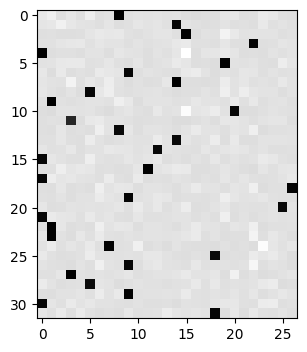

In [74]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

# Exercise 3

Backprop through batchnorm but all in one go to complete this challenge look at the mathematical expression of the output of batchnorm, take the derivative w.r.t. its input, simplify the expression, and just write it out

In [75]:
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [76]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [77]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [78]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7995
  10000/ 200000: 2.1618


KeyboardInterrupt: 

In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070523500442505
val 2.109893560409546


In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzamille.
khi.
mreigeet.
khalaysie.
mahnen.
delynn.
jareen.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quinn.
shoison.
jadiquintero.
dearyxi.
jace.
pinsley.
dae.
iia.
